# 03.6 - Feature Selection and Final Cleanup

This notebook removes unnecessary features based on correlation analysis findings and fixes issues identified in the augmented dataset.

**Goals:**
- Remove target leakage (positionOrder)
- Remove highly correlated redundant features
- Simplify rolling window features (keep only most informative windows)
- Remove complementary features (finished_rate vs dnf_rate)
- Perform final correlation analysis to validate feature set

**Input:** `data/processed/master_races_augmented.csv` (from 03.5)  
**Output:** Cleaned dataset ready for modeling


In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = Path(r"C:/Users/erikv/Downloads/F1").resolve()
PROCESSED_ROOT = PROJECT_ROOT / "data" / "processed"

# Check if augmented file exists
augmented_file = PROCESSED_ROOT / "master_races_augmented.csv"
if not augmented_file.exists():
    print(f"ERROR: {augmented_file} not found!")
    print("Please run notebook 03.5_data_augmentation.ipynb first to create the augmented dataset.")
    raise FileNotFoundError(f"Required file not found: {augmented_file}")

print(f"Loading augmented dataset from: {augmented_file}")
print("This may take a moment...")

# Load augmented dataset from 03.5
try:
    master = pd.read_csv(augmented_file)
    print(f"✓ Loaded successfully: {master.shape[0]:,} rows × {master.shape[1]} columns")
except Exception as e:
    print(f"ERROR loading file: {e}")
    raise

# Convert date column
print("Converting date column...")
master['date'] = pd.to_datetime(master['date'], errors='coerce')
print("✓ Date conversion complete")

# Sort by date to ensure proper temporal ordering
print("Sorting by date...")
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)
print("✓ Sorting complete")

print(f"\nDataset shape: {master.shape}")
print(f"Memory usage: {master.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date range: {master['date'].min()} to {master['date'].max()}")

# Set plotting style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

Loading augmented dataset from: C:\Users\erikv\Downloads\F1\data\processed\master_races_augmented.csv
This may take a moment...
✓ Loaded successfully: 12,358 rows × 120 columns
Converting date column...
✓ Date conversion complete
Sorting by date...
✓ Sorting complete

Dataset shape: (12358, 120)
Memory usage: 35.55 MB
Date range: 1994-03-27 00:00:00 to 2024-12-08 00:00:00


## 1. Remove Target Leakage

**positionOrder** (finishing position) is the outcome variable used to create the target `podium`. Using it as a feature would be data leakage since we're predicting podium before the race finishes.

**Action:** Remove `positionOrder` from features (keep it only for creating/validating the target).


In [12]:
# Remove positionOrder (target leakage - this is the outcome, not a predictor)
if 'positionOrder' in master.columns:
    print("Removing positionOrder (target leakage)")
    master = master.drop(columns=['positionOrder'])
    print(f"  Removed. New shape: {master.shape}")
else:
    print("positionOrder not found (already removed?)")


Removing positionOrder (target leakage)
  Removed. New shape: (12358, 119)


## 2. Remove Highly Correlated Pre-Race Standings

**constructor_standings_points_PRE_RACE** is highly correlated (r=0.924) with `driver_standings_points_PRE_RACE`. Since we're predicting individual driver podium, driver standings are more directly relevant.

**Action:** Remove `constructor_standings_points_PRE_RACE` (keep driver version).


In [13]:
# Remove constructor_standings_points_PRE_RACE (highly correlated with driver version)
if 'constructor_standings_points_PRE_RACE' in master.columns:
    print("Removing constructor_standings_points_PRE_RACE (r=0.924 with driver version)")
    master = master.drop(columns=['constructor_standings_points_PRE_RACE'])
    print(f"  Removed. New shape: {master.shape}")
else:
    print("constructor_standings_points_PRE_RACE not found (already removed?)")


Removing constructor_standings_points_PRE_RACE (r=0.924 with driver version)
  Removed. New shape: (12358, 118)


## 3. Simplify Rolling Window Features (3, 5, 10 → Keep Only 10)

Rolling features with windows 3, 5, and 10 are highly correlated (r > 0.7). The longer window (10) captures more stable, long-term trends which are more informative for prediction.

**Features affected:**
- `driver_podium_rate_last_3/5/10` → Keep only `_last_10`
- `driver_avg_grid_last_3/5/10` → Keep only `_last_10`
- `constructor_podium_rate_last_3/5/10` → Keep only `_last_10`
- `dnf_rate_last_3/5/10` → Keep only `_last_10`
- `finished_lapped_rate_last_3/5/10` → Keep only `_last_10`
- `disqualified_rate_last_3/5/10` → Keep only `_last_10`
- `not_classified_rate_last_3/5/10` → Keep only `_last_10`

**Action:** Remove `_last_3` and `_last_5` versions, keep only `_last_10`.


In [14]:
# Remove rolling features with windows 3 and 5 (keep only 10)
# These are highly correlated and the longer window captures more stable trends
features_to_remove_3_5 = [
    'driver_podium_rate_last_3',
    'driver_podium_rate_last_5',
    'driver_avg_grid_last_3',
    'driver_avg_grid_last_5',
    'constructor_podium_rate_last_3',
    'constructor_podium_rate_last_5',
    'dnf_rate_last_3',
    'dnf_rate_last_5',
    'finished_lapped_rate_last_3',
    'finished_lapped_rate_last_5',
    'disqualified_rate_last_3',
    'disqualified_rate_last_5',
    'not_classified_rate_last_3',
    'not_classified_rate_last_5',
]

print("Removing rolling features with windows 3 and 5 (keeping only 10):")
removed_count = 0
for col in features_to_remove_3_5:
    if col in master.columns:
        print(f"  - {col}")
        master = master.drop(columns=[col])
        removed_count += 1

print(f"\nRemoved {removed_count} features. New shape: {master.shape}")


Removing rolling features with windows 3 and 5 (keeping only 10):
  - driver_podium_rate_last_3
  - driver_podium_rate_last_5
  - driver_avg_grid_last_3
  - driver_avg_grid_last_5
  - constructor_podium_rate_last_3
  - constructor_podium_rate_last_5
  - dnf_rate_last_3
  - dnf_rate_last_5
  - finished_lapped_rate_last_3
  - finished_lapped_rate_last_5
  - disqualified_rate_last_3
  - disqualified_rate_last_5
  - not_classified_rate_last_3
  - not_classified_rate_last_5

Removed 14 features. New shape: (12358, 104)


## 4. Simplify Rolling Window Features (3, 5 → Keep Only 5)

For features with only 3 and 5 window options (e.g., sprint points), keep the longer window (5) for more stable estimates.

**Features affected:**
- `driver_sprint_points_avg_last_3` → Remove, keep `_last_5`

**Action:** Remove `_last_3` version.


In [15]:
# Remove rolling features with window 3 (keep only 5)
# For sprint points, keep the longer window for more stable estimates
if 'driver_sprint_points_avg_last_3' in master.columns:
    print("Removing driver_sprint_points_avg_last_3 (keeping _last_5)")
    master = master.drop(columns=['driver_sprint_points_avg_last_3'])
    print(f"  Removed. New shape: {master.shape}")
else:
    print("driver_sprint_points_avg_last_3 not found (already removed?)")


Removing driver_sprint_points_avg_last_3 (keeping _last_5)
  Removed. New shape: (12358, 103)


## 5. Remove Finished Rate Features (Complementary to DNF Rate)

`finished_rate` and `dnf_rate` are perfectly negatively correlated (they sum to ~1). Since we're predicting podium (which requires finishing), DNF rate is more informative - it directly tells us the probability of not finishing.

**Action:** Remove all `finished_rate` columns, keep `dnf_rate`.


In [16]:
# Remove all finished_rate columns (complementary to dnf_rate)
finished_rate_cols = [col for col in master.columns if 'finished_rate' in col]

print("Removing finished_rate columns (complementary to dnf_rate):")
removed_count = 0
for col in finished_rate_cols:
    print(f"  - {col}")
    master = master.drop(columns=[col])
    removed_count += 1

print(f"\nRemoved {removed_count} features. New shape: {master.shape}")


Removing finished_rate columns (complementary to dnf_rate):
  - finished_rate_last_3
  - finished_rate_last_5
  - finished_rate_last_10

Removed 3 features. New shape: (12358, 100)


## 6. Remove Driver Average Position (Redundant with Podium Rate)

`driver_avg_position` is highly correlated with `driver_podium_rate` (r > 0.7). For predicting podium, the podium rate is more directly relevant and interpretable.

**Note:** For circuit-specific features, we keep BOTH `driver_avg_position_at_circuit` and `driver_podium_rate_at_circuit` as they may capture different aspects of circuit-specific performance.

**Action:** Remove rolling `driver_avg_position_last_10`, keep `driver_podium_rate_last_10`.


In [17]:
# Remove driver_avg_position_last_10 (redundant with driver_podium_rate_last_10)
# Note: Keep circuit-specific driver_avg_position_at_circuit (different context)
if 'driver_avg_position_last_10' in master.columns:
    print("Removing driver_avg_position_last_10 (redundant with driver_podium_rate_last_10)")
    master = master.drop(columns=['driver_avg_position_last_10'])
    print(f"  Removed. New shape: {master.shape}")
    print("  Note: Keeping driver_avg_position_at_circuit (circuit-specific context)")
else:
    print("driver_avg_position_last_10 not found (already removed?)")


Removing driver_avg_position_last_10 (redundant with driver_podium_rate_last_10)
  Removed. New shape: (12358, 99)
  Note: Keeping driver_avg_position_at_circuit (circuit-specific context)


## 7. Summary of Removals

Summary of all features removed and rationale.


In [18]:
# Load original augmented dataset to compare
original_augmented = pd.read_csv(PROCESSED_ROOT / "master_races_augmented.csv")
removed_features = [col for col in original_augmented.columns if col not in master.columns]

print("="*70)
print("FEATURE REMOVAL SUMMARY")
print("="*70)
print(f"\nOriginal augmented shape: {original_augmented.shape}")
print(f"Final shape: {master.shape}")
print(f"Features removed: {len(removed_features)}")
print(f"Features remaining: {master.shape[1]}")

print("\n" + "="*70)
print("REMOVED FEATURES BY CATEGORY")
print("="*70)

removal_categories = {
    'Target Leakage': ['positionOrder'],
    'Highly Correlated Pre-Race': ['constructor_standings_points_PRE_RACE'],
    'Rolling Windows 3 & 5 (kept 10)': [f for f in removed_features if any(x in f for x in ['_last_3', '_last_5']) and '_last_10' not in f],
    'Rolling Windows 3 (kept 5)': [f for f in removed_features if '_last_3' in f and 'sprint' in f],
    'Finished Rate (kept DNF rate)': [f for f in removed_features if 'finished_rate' in f],
    'Driver Avg Position (kept podium rate)': [f for f in removed_features if 'driver_avg_position_last' in f],
}

for category, features in removal_categories.items():
    if features:
        print(f"\n{category}:")
        for feat in sorted(features):
            if feat in removed_features:
                print(f"  - {feat}")

print("\n" + "="*70)
print("KEY FEATURES RETAINED")
print("="*70)
print("\nRolling Features (last 10 races):")
retained_rolling = [f for f in master.columns if '_last_10' in f]
for feat in sorted(retained_rolling):
    print(f"  - {feat}")

print("\nCircuit-Specific Features (all history):")
retained_circuit = [f for f in master.columns if 'circuit' in f]
for feat in sorted(retained_circuit):
    print(f"  - {feat}")

print("\n" + "="*70)


FEATURE REMOVAL SUMMARY

Original augmented shape: (12358, 120)
Final shape: (12358, 99)
Features removed: 21
Features remaining: 99

REMOVED FEATURES BY CATEGORY

Target Leakage:
  - positionOrder

Highly Correlated Pre-Race:
  - constructor_standings_points_PRE_RACE

Rolling Windows 3 & 5 (kept 10):
  - constructor_podium_rate_last_3
  - constructor_podium_rate_last_5
  - disqualified_rate_last_3
  - disqualified_rate_last_5
  - dnf_rate_last_3
  - dnf_rate_last_5
  - driver_avg_grid_last_3
  - driver_avg_grid_last_5
  - driver_podium_rate_last_3
  - driver_podium_rate_last_5
  - driver_sprint_points_avg_last_3
  - finished_lapped_rate_last_3
  - finished_lapped_rate_last_5
  - finished_rate_last_3
  - finished_rate_last_5
  - not_classified_rate_last_3
  - not_classified_rate_last_5

Rolling Windows 3 (kept 5):
  - driver_sprint_points_avg_last_3

Finished Rate (kept DNF rate):
  - finished_rate_last_10
  - finished_rate_last_3
  - finished_rate_last_5

Driver Avg Position (kept pod

## 8. Final Correlation Analysis

Perform comprehensive correlation analysis on the cleaned feature set to:
- Validate that multicollinearity has been reduced
- Identify any remaining highly correlated pairs
- Understand relationships between features and target
- Guide final feature selection decisions


Features selected for correlation analysis: 20
Features: podium, grid, points, driver_standings_points_PRE_RACE, driver_standings_position_PRE_RACE, constructor_standings_position_PRE_RACE, driver_points_avg_last_10, driver_podium_rate_last_10, driver_avg_grid_last_10, constructor_podium_rate_last_10...


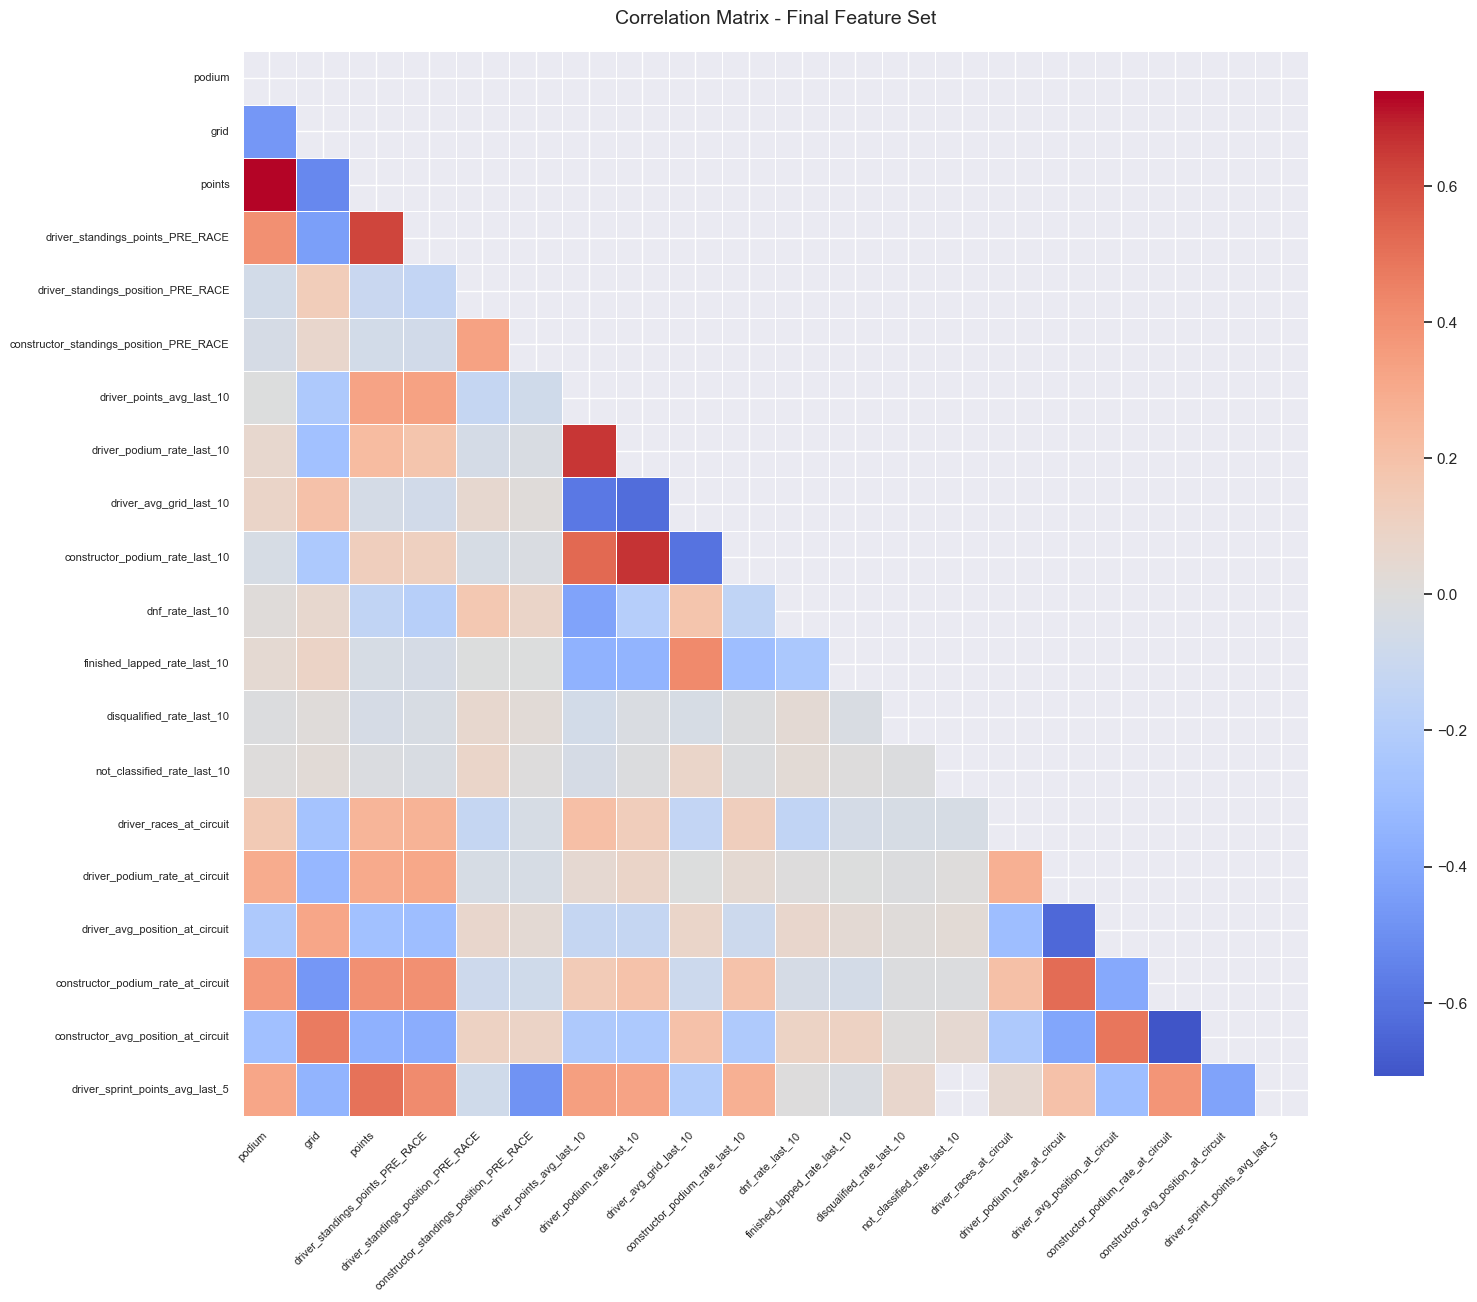


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)
These features may still be redundant - consider further review

constructor_podium_rate_at_circuit            <-> constructor_avg_position_at_circuit           : -0.708

Total highly correlated pairs found: 1

Note: Some correlation is expected (e.g., circuit features may correlate with rolling features)

TOP CORRELATIONS WITH PODIUM

Top 20 features most correlated with podium:
  points                                             :  0.739 (positive)
  grid                                               : -0.469 (negative)
  driver_standings_points_PRE_RACE                   :  0.401 (positive)
  constructor_podium_rate_at_circuit                 :  0.367 (positive)
  driver_sprint_points_avg_last_5                    :  0.315 (positive)
  driver_podium_rate_at_circuit                      :  0.293 (positive)
  constructor_avg_position_at_circuit                : -0.285 (negative)
  driver_avg_position_at_circuit                     : -0.223

In [19]:
# Select key numeric features for correlation analysis
key_features = [
    # Target
    'podium',
    # Original strong predictors
    'grid', 'points',
    # Pre-race standings
    'driver_standings_points_PRE_RACE', 'driver_standings_position_PRE_RACE',
    'constructor_standings_position_PRE_RACE',
    # Rolling points
    'driver_points_avg_last_10',
    # Driver rolling features (last 10)
    'driver_podium_rate_last_10',
    'driver_avg_grid_last_10',
    # Constructor rolling features (last 10)
    'constructor_podium_rate_last_10',
    # Status rates (last 10)
    'dnf_rate_last_10',
    'finished_lapped_rate_last_10',
    'disqualified_rate_last_10',
    'not_classified_rate_last_10',
    # Circuit features
    'driver_races_at_circuit',
    'driver_podium_rate_at_circuit', 'driver_avg_position_at_circuit',
    'constructor_podium_rate_at_circuit', 'constructor_avg_position_at_circuit',
    # Season trends
    'driver_position_trend_season',
    # Sprint features
    'driver_sprint_points_avg_last_5',
]

# Filter to features that exist in the dataset
available_features = [f for f in key_features if f in master.columns]
numeric_available = [f for f in available_features if master[f].dtype in [np.int64, np.float64]]

print(f"Features selected for correlation analysis: {len(numeric_available)}")
print(f"Features: {', '.join(numeric_available[:10])}...")

# Calculate correlation matrix
if len(numeric_available) > 1:
    feature_corr = master[numeric_available].corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(feature_corr, dtype=bool))
    
    # Plot correlation heatmap
    plt.figure(figsize=(16, 14))
    sns.heatmap(feature_corr, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=feature_corr.columns, yticklabels=feature_corr.columns)
    plt.title('Correlation Matrix - Final Feature Set', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs (excluding self-correlations and podium)
    high_corr_pairs = []
    for i in range(len(feature_corr.columns)):
        for j in range(i+1, len(feature_corr.columns)):
            feat1 = feature_corr.columns[i]
            feat2 = feature_corr.columns[j]
            # Skip if either is podium (we want to see correlations WITH podium, not between features)
            if feat1 == 'podium' or feat2 == 'podium':
                continue
            corr_val = feature_corr.iloc[i, j]
            if abs(corr_val) > 0.7:  # Threshold for high correlation
                high_corr_pairs.append({
                    'feature1': feat1,
                    'feature2': feat2,
                    'correlation': corr_val
                })
    
    # Sort by absolute correlation
    high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)
    
    print("\n" + "="*70)
    print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
    print("="*70)
    print("These features may still be redundant - consider further review\n")
    
    if high_corr_pairs:
        for pair in high_corr_pairs:
            print(f"{pair['feature1']:45s} <-> {pair['feature2']:45s} : {pair['correlation']:6.3f}")
        
        print(f"\nTotal highly correlated pairs found: {len(high_corr_pairs)}")
        print("\nNote: Some correlation is expected (e.g., circuit features may correlate with rolling features)")
    else:
        print("No highly correlated pairs found (|r| > 0.7)")
        print("This is good - features are relatively independent")
    
    # Correlations with podium
    if 'podium' in feature_corr.columns:
        podium_corr = feature_corr['podium'].drop('podium').abs().sort_values(ascending=False)
        
        print("\n" + "="*70)
        print("TOP CORRELATIONS WITH PODIUM")
        print("="*70)
        print("\nTop 20 features most correlated with podium:")
        for feat, corr in podium_corr.head(20).items():
            actual_corr = feature_corr.loc[feat, 'podium']
            direction = "positive" if actual_corr > 0 else "negative"
            print(f"  {feat:50s} : {actual_corr:6.3f} ({direction})")
        
        print("\nInterpretation:")
        print("- Positive correlation: Higher values associated with higher podium probability")
        print("- Negative correlation: Higher values associated with lower podium probability")
        print("- For position-related features: Lower position = better, so negative correlation is expected")
else:
    print("Not enough numeric features available for correlation analysis")


In [20]:
# Save final cleaned dataset
output_path = PROCESSED_ROOT / "master_races_final.csv"
master.to_csv(output_path, index=False)
print(f"Final cleaned dataset saved to: {output_path}")
print(f"  Rows: {master.shape[0]:,}")
print(f"  Columns: {master.shape[1]}")
print(f"  File size: {output_path.stat().st_size / 1024**2:.2f} MB")

# Compare with original
original = pd.read_csv(PROCESSED_ROOT / "master_races.csv")
print(f"\nComparison:")
print(f"  Original: {original.shape[0]:,} rows × {original.shape[1]} columns")
print(f"  Final:    {master.shape[0]:,} rows × {master.shape[1]} columns")
print(f"  Net change: +{master.shape[1] - original.shape[1]} columns")


Final cleaned dataset saved to: C:\Users\erikv\Downloads\F1\data\processed\master_races_final.csv
  Rows: 12,358
  Columns: 99
  File size: 7.33 MB

Comparison:
  Original: 12,358 rows × 82 columns
  Final:    12,358 rows × 99 columns
  Net change: +17 columns
